# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# Вынес блок загрузки библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()
data.head(5)
# На первом этапе необходимо изучить данные в датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


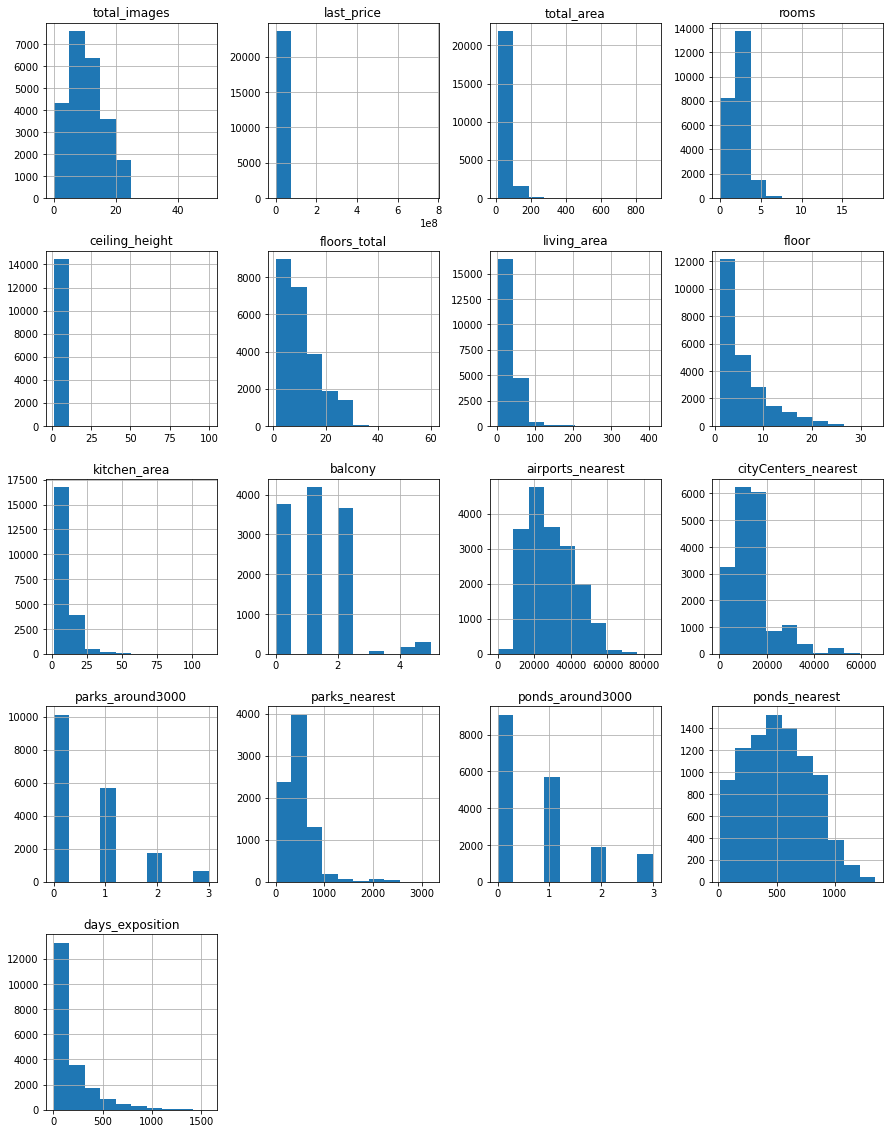

In [3]:
data.hist(figsize=(15, 20)); # убрал служебную информацию

**Вывод**: в датасете 23699 строк, на первый взгляд имеются пропуски (например, kitchen area), некорректный тип данных( например, floors_total), а также, скорее всего, присутсвуют аномальные значения

### Предобработка данных

Далее необходимо провести обработку данных: заполнить пропуски 0, поменять тип переменной, заполнить значения медианой - все в зависимости от данных в столбцах

In [6]:
# Поменяем неверно (не по правилам) записанную переменную
data.rename (columns = {'cityCenters_nearest':'city_centers_nearest' }, inplace = True)

# заменим высоту потолков, расстояния до парков и аэропортов на медианные (важно, что не средние - иначе исказятся данные) значения
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)
data['airports_nearest'].fillna(data['airports_nearest'].median(), inplace=True)
data['parks_nearest'].fillna(data['parks_nearest'].median(), inplace=True)
data['ponds_nearest'].fillna(data['ponds_nearest'].median(), inplace=True)

# Пропущенные значения площади кухни и жилого помещения заменяем на средние значения - так проще, чем с точностью высчитывать каждую отдельную площадь
living_square = data['living_area'].mean() / data['total_area'].mean()
kitchen_square = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_square * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_square * data['total_area'], inplace=True)


# Пропущенные значения  заменяем на "Нет" - в России чаще всего встречаются "не апартаменты"
data['is_apartment'] = data['is_apartment'].fillna(False)

# Удалим этажность и имя населенного пункта - иначе гадать можно очень долго
data.dropna(subset=['locality_name'], inplace=True)
data.dropna(subset=['floors_total'], inplace=True)

# Меняем тип данных для удобства дальнейшего анализа
data['balcony'] = data['balcony'].fillna(value = 0)
data['balcony'] = data['balcony'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')
data['parks_around3000'] = data['parks_around3000'].fillna(value = 0).astype('int')
data['ponds_around3000'] = data['ponds_around3000'].fillna(value = 0).astype('int')
data['days_exposition'] = data['days_exposition'].fillna(value = 0).astype('int')

# Меняем формат времени
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')


data.isnull().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest           0
city_centers_nearest    5501
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition            0
dtype: int64

**Вывод:** В данном случае мы избавились от пропусков. По-максимуму, в зависимости от данных в переменных были проведенены соответсвующие операции. Далее очистим еще некоторые аномалии, которые можно найти в данных.

In [7]:

data[data['total_area']*0.9 <= (data ['living_area']+data ['kitchen_area'])][['total_area'
                                                                                  ,'living_area','kitchen_area']]

,total_area,living_area,kitchen_area
41,74.0,59.0,12.000000
171,49.0,38.0,10.000000
184,30.2,26.1,6.200000
220,37.0,28.0,9.000000
319,59.7,47.4,6.400000
...,...,...,...
23297,48.2,42.2,6.000000
23328,54.0,40.0,10.000000
23521,65.0,44.0,15.300000
23579,24.8,18.0,4.343614


In [8]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок городского типа')
data['locality_name'].unique()

array(['санкт-петербург', 'поселок шушары',
       'поселок городского типа янино-1', 'поселок парголово',
       'поселок мурино', 'ломоносов', 'сертолово', 'петергоф', 'пушкин',
       'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина',
       'деревня федоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'поселок металлострой',
       'поселок городского типа лебяжье',
       'поселок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'поселок аннино',
       'поселок городского типа ефимовский', 'поселок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'поселок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'посел

На первом этапе обработали аномалии в названиях населенных пунктов, далее обратимся к устранению аномалий в высоте потолков


In [9]:
data.loc[(data['ceiling_height']>=10), 'ceiling_height'] = data.loc[(data['ceiling_height']>=10), 'ceiling_height']/ 5
data['ceiling_height'].unique()      

array([ 2.7 ,  2.65,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  3.2 ,  2.61,  3.25,  3.45,  2.77,
        2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,  2.47,
        2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,  2.51,
        2.78,  2.76,  5.  ,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,
        2.59,  2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,
        3.55,  3.16,  3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.3 ,
        2.79,  2.95,  4.06,  2.94,  3.82,  3.54,  3.53,  2.83,  4.7 ,
        2.4 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,  2.3 ,
        3.57,  2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,  3.95,
        3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,  3.24,
        4.8 ,  4.5 ,  4.2 ,  3.36,  6.4 ,  3.08,  3.68,  3.07,  3.37,
        3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,
        2.68,  3.22,  3.27,  5.4 ,  4.1 ,  2.93,  3.46,  3.47,  3.33,
        3.63,  3.32,

**Вывод:** В результате выполнения кода удалось избавиться от откровенно неверных значений в высоте потолков, а также в ошибках в названии населенных пунктов

In [12]:

data = data[data['floors_total']<30]
data = data[data['rooms']<5]
data = data[data['total_area']<200]

# Предположим, что в СПБ нет домов выше 30 этажей

In [13]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00"
min,0.00,12.00,1.00,0.00,"12,190.00",2.00,1.30,1.00,1.00
max,4.00,199.20,20.00,"1,580.00","330,000,000.00",164.70,93.20,27.00,29.00


In [14]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,7994
2,7881
3,5759
4,1130
0,191


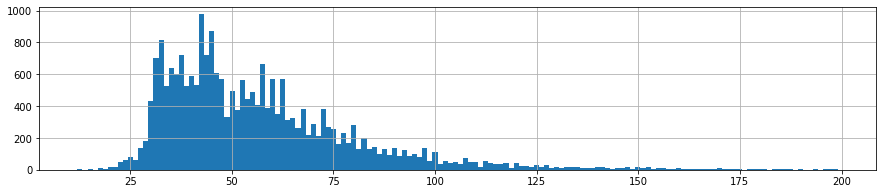

In [15]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

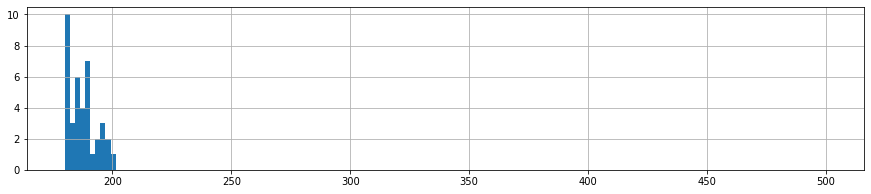

In [16]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

In [17]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00"
min,0.00,12.00,1.00,0.00,"12,190.00",2.00,1.30,1.00,1.00
max,4.00,199.20,20.00,"1,580.00","330,000,000.00",164.70,93.20,27.00,29.00


#### check nan

In [18]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22955 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22955 non-null  int64         
 1   last_price            22955 non-null  float64       
 2   total_area            22955 non-null  float64       
 3   first_day_exposition  22955 non-null  datetime64[ns]
 4   rooms                 22955 non-null  int64         
 5   ceiling_height        22955 non-null  float64       
 6   floors_total          22955 non-null  int64         
 7   living_area           22955 non-null  float64       
 8   floor                 22955 non-null  int64         
 9   is_apartment          22955 non-null  bool          
 10  studio                22955 non-null  bool          
 11  open_plan             22955 non-null  bool          
 12  kitchen_area          22955 non-null  float64       
 13  balcony         

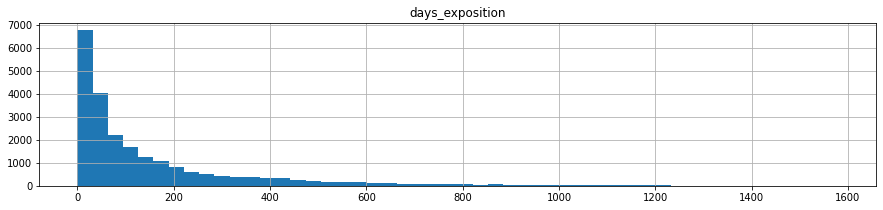

In [19]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3));

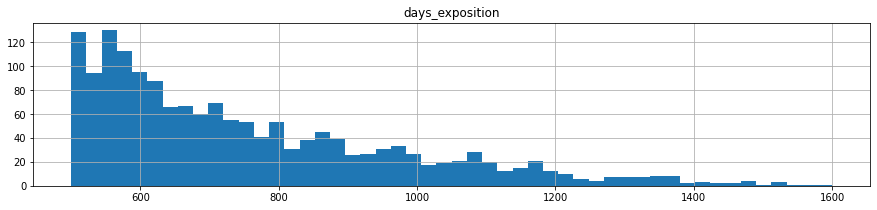

In [20]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (500, 1600));

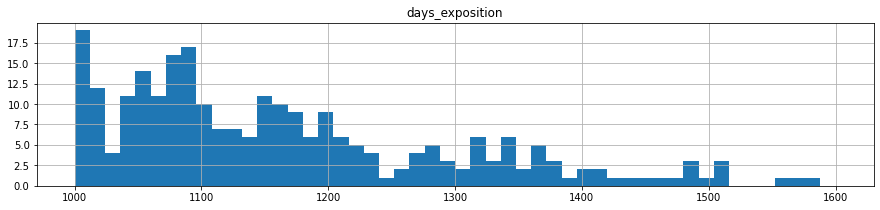

In [21]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (1000, 1600));

In [22]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир


(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00","22,955.00"
min,0.00,12.00,1.00,0.00,"12,190.00",2.00,1.30,1.00,1.00
max,4.00,199.20,20.00,"1,580.00","330,000,000.00",164.70,93.20,27.00,29.00


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22955 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22955 non-null  int64         
 1   last_price            22955 non-null  float64       
 2   total_area            22955 non-null  float64       
 3   first_day_exposition  22955 non-null  datetime64[ns]
 4   rooms                 22955 non-null  int64         
 5   ceiling_height        22955 non-null  float64       
 6   floors_total          22955 non-null  int64         
 7   living_area           22955 non-null  float64       
 8   floor                 22955 non-null  int64         
 9   is_apartment          22955 non-null  bool          
 10  studio                22955 non-null  bool          
 11  open_plan             22955 non-null  bool          
 12  kitchen_area          22955 non-null  float64       
 13  balcony         

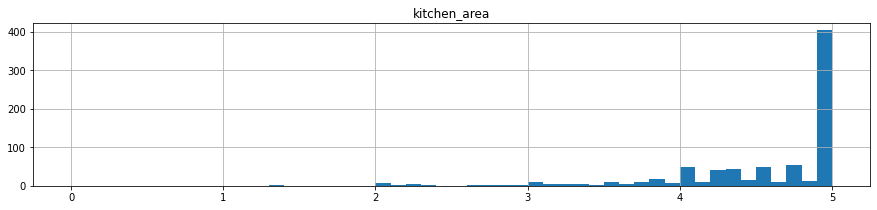

In [24]:
# check
data.hist(column = 'kitchen_area', bins = 50, figsize = (15,3), range = (0,5));

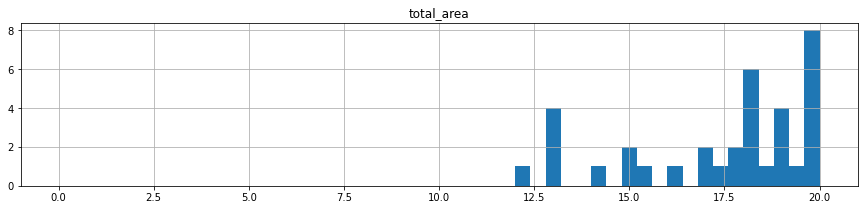

In [25]:
# check
data.hist(column = 'total_area', bins = 50, figsize = (15,3), range = (0,20));

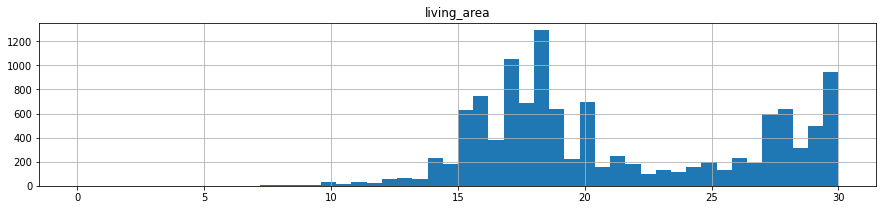

In [26]:
data.hist(column = 'living_area', bins = 50, figsize = (15,3), range = (0,30));

In [27]:
# check 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22955 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22955 non-null  int64         
 1   last_price            22955 non-null  float64       
 2   total_area            22955 non-null  float64       
 3   first_day_exposition  22955 non-null  datetime64[ns]
 4   rooms                 22955 non-null  int64         
 5   ceiling_height        22955 non-null  float64       
 6   floors_total          22955 non-null  int64         
 7   living_area           22955 non-null  float64       
 8   floor                 22955 non-null  int64         
 9   is_apartment          22955 non-null  bool          
 10  studio                22955 non-null  bool          
 11  open_plan             22955 non-null  bool          
 12  kitchen_area          22955 non-null  float64       
 13  balcony         

In [28]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.01,1.00,25.20,2.50,0.00,"1,000,000.00",13.00,4.38,1.00,2.00
0.5,2.00,51.00,2.65,73.00,"4,575,000.00",30.00,9.00,4.00,9.00
0.9,3.00,87.80,3.00,421.00,"9,990,000.00",52.00,15.00,13.00,22.00
0.9976,4.00,173.92,4.10,"1,274.82","47,700,000.00",101.98,44.70,25.00,27.00


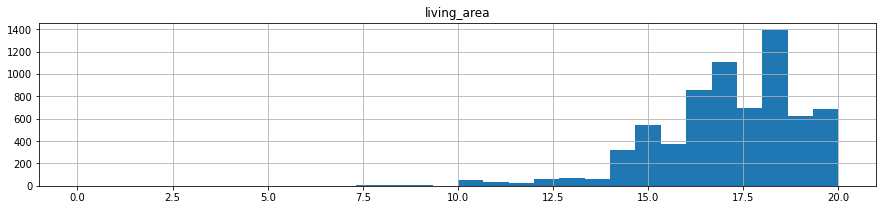

In [29]:
# check
data.hist(column = 'living_area', bins = 30, figsize = (15,3), range = (0, 20));

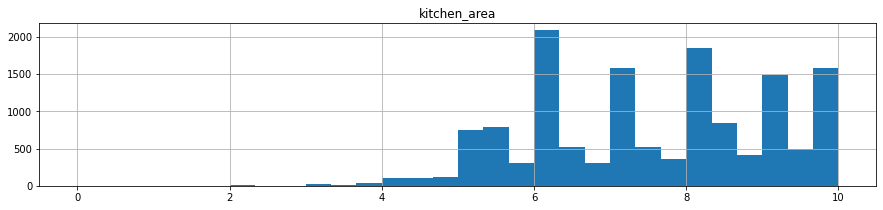

In [30]:
# check
data.hist(column = 'kitchen_area', bins = 30, figsize = (15,3), range = (0, 10));

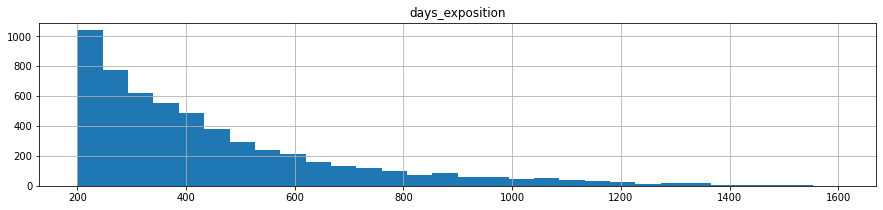

In [31]:
# check
data.hist(column = 'days_exposition', bins = 30, figsize = (15,3), range = (200, 1600));

In [33]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир


(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"18,703.00","18,703.00","18,703.00","18,703.00","18,703.00","18,703.00","18,703.00","18,703.00","18,703.00"
min,0.00,24.00,2.45,0.00,"430,000.00",15.01,5.01,1.00,1.00
max,4.00,179.70,4.80,399.00,"124,000,000.00",99.92,39.90,27.00,28.00


### Проведите исследовательский анализ данных

1) Находим цену одного кватратного метра жилья и добавляем ее в новый столбец


In [34]:
data['price_meter'] = data['last_price'] / data['total_area']
data['price_meter'] = data['price_meter'].astype('int')
print(data['price_meter'].head(10))

0     120370
1      82920
7     110544
8      87454
9      88524
10    127525
11     75000
12     72037
13     82943
14    122222
Name: price_meter, dtype: int64


2) Укажем день публикации объявления и добавим ее в новый столбец

In [35]:
data['day'] = data['first_day_exposition'].dt.weekday
print(data['day'].head(10))

0     3
1     1
7     3
8     2
9     6
10    3
11    0
12    3
13    5
14    3
Name: day, dtype: int64


3) Укажем месяц публикации и добавим ее в новый столбец

In [36]:
data['month'] = data['first_day_exposition'].dt.month
print(data['month'].head(10))

0      3
1     12
7      4
8      5
9      2
10    11
11     8
12     6
13     7
14     6
Name: month, dtype: int64


4) Укажем год публикации и добавим его в новый столбец

In [37]:
data['year'] = data['first_day_exposition'].dt.year
print(data['year'].head(10))

0     2019
1     2018
7     2019
8     2018
9     2017
10    2017
11    2018
12    2016
13    2017
14    2016
Name: year, dtype: int64


5) Укажем тип этажа квартиры и добавим его в новый столбец

In [38]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_status'] = data.apply(floor_type, axis=1)
print(data['floor_status'].head(10))    

0        другой
1        первый
7        другой
8        другой
9        другой
10       другой
11       другой
12    последний
13    последний
14       первый
Name: floor_status, dtype: object


6) Укажем расстояние до центра города в километрах и добавим его в новый столбец

In [39]:
data['city_centers_nearest_km'] = data['city_centers_nearest'] / 1000
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].fillna(value=0).astype(int)
print(data['city_centers_nearest_km'].head(10))

0     16
1     18
7     11
8      0
9     15
10    13
11    51
12     0
13    33
14    30
Name: city_centers_nearest_km, dtype: int64


Необходимо провести проверку, что все строки кода выполнились корректно

In [40]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,day,month,year,floor_status,city_centers_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2,755.0,0,120370,3,3,2019,другой,16
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,455.0,0,502.0,81,82920,1,12,2018,первый,18
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,40.882144,22,False,...,455.0,0,502.0,0,110544,3,4,2019,другой,11
8,20,2900000.0,33.16,2018-05-23,1,2.65,27,15.430000,26,False,...,455.0,0,502.0,189,87454,2,5,2018,другой,0
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,455.0,0,502.0,289,88524,6,2,2017,другой,15


**Вывод:** все корректно, можно приступать к исследовательскому анализу данных

### Изучаем следующие параметры объектов:
 - общая площадь;
 -  жилая площадь;
 - площадь кухни;
 - цена объекта;
 - количество комнат;
 - высота потолков;
 - этаж квартиры;
 - тип этажа квартиры («первый», «последний», «другой»);
 - общее количество этажей в доме;
 -  расстояние до центра города в метрах;
 -  расстояние до ближайшего аэропорта;
 -  расстояние до ближайшего парка;
 -  день и месяц публикации объявления.

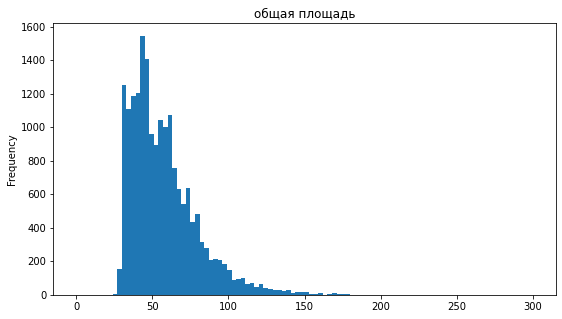

In [41]:
data['total_area'].plot(kind = 'hist', title = 'общая площадь', bins = 100, figsize = (9,5), range = (0,300));

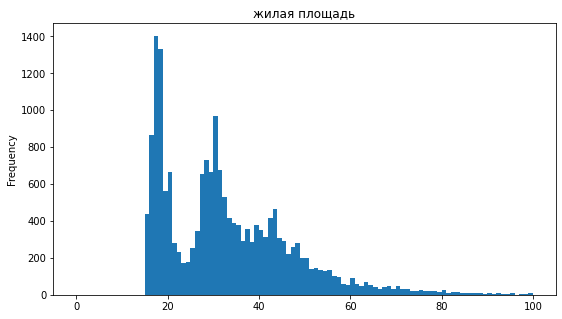

In [42]:
data['living_area'].plot(kind = 'hist', title = 'жилая площадь', bins = 100, figsize = (9,5), range = (0,100));

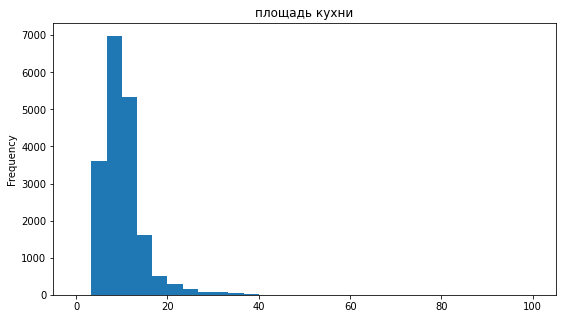

In [43]:
data['kitchen_area'].plot(kind = 'hist', title = 'площадь кухни', bins = 30, figsize = (9,5), range = (0,100));

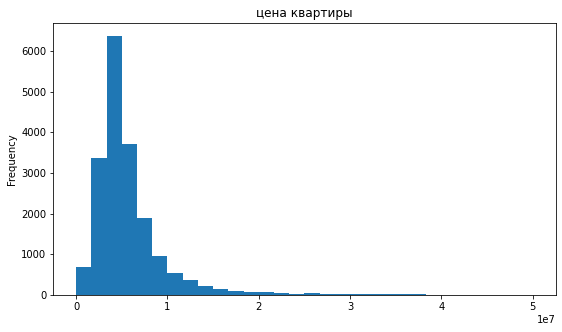

In [44]:
data['last_price'].plot( kind = 'hist',title = 'цена квартиры', bins = 30, range = (0,50000000), figsize = (9,5));

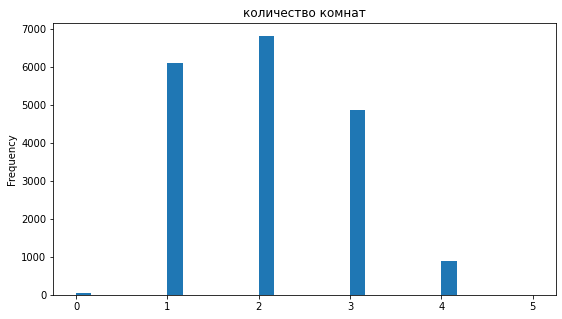

In [45]:
data['rooms'].plot( kind = 'hist',title = 'количество комнат', bins = 30, range = (0,5), figsize = (9,5));

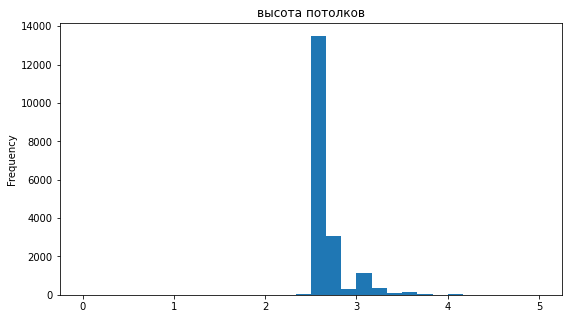

In [46]:
data['ceiling_height'].plot( kind = 'hist',title = 'высота потолков', bins = 30, range = (0,5), figsize = (9,5));

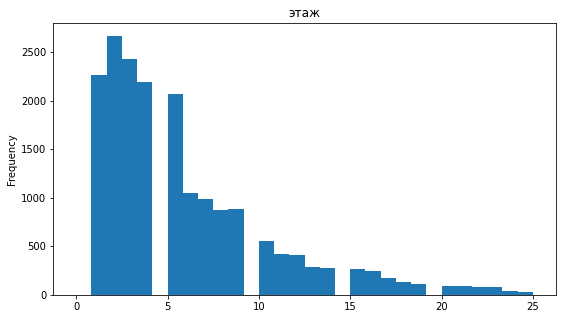

In [47]:
data['floor'].plot( kind = 'hist',title = 'этаж', bins = 30 , range = (0,25), figsize = (9,5));

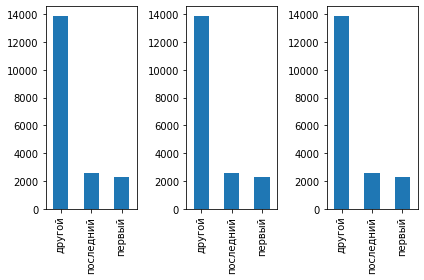

In [48]:
fig, axs = plt.subplots(1,3)
data['floor_status'].value_counts().plot(ax = axs[0], kind = 'bar')
data['floor_status'].value_counts().plot(ax = axs[1], kind = 'bar')
data['floor_status'].value_counts().plot(ax = axs[2], kind = 'bar')
plt.tight_layout()

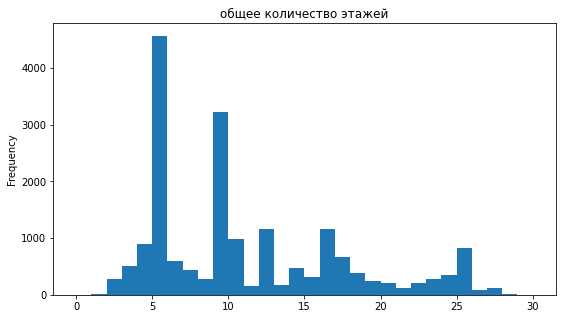

In [49]:
data['floors_total'].plot( kind = 'hist',title = 'общее количество этажей', bins = 30, range = (0,30), figsize = (9,5));

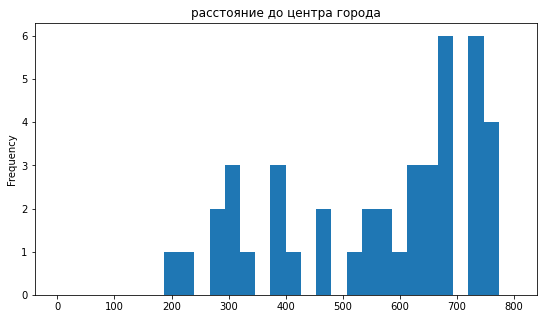

In [50]:
data['city_centers_nearest'].plot( kind = 'hist',title = 'расстояние до центра города', bins = 30 , range = (0,800), figsize = (9,5));

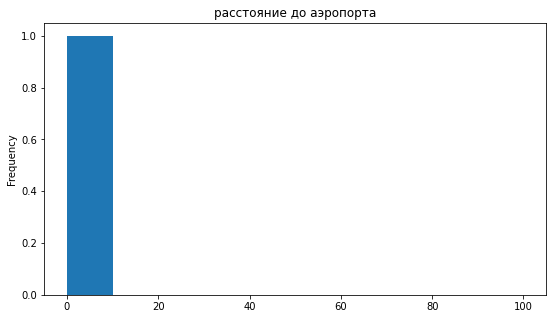

In [51]:
data['airports_nearest'].plot( kind = 'hist',title = 'расстояние до аэропорта', bins = 10 , range = (0,100), figsize = (9,5));

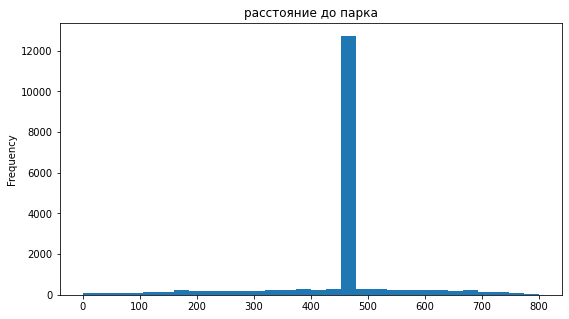

In [52]:
data['parks_nearest'].plot( kind = 'hist',title = 'расстояние до парка', bins = 30 , range = (0,800), figsize = (9,5));

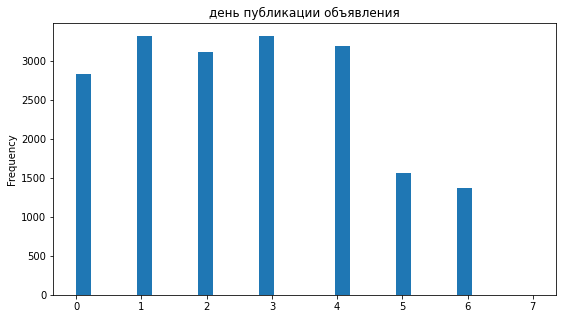

In [53]:
data['day'].plot( kind = 'hist',title = 'день публикации объявления', bins = 30 , range = (0,7), figsize = (9,5));

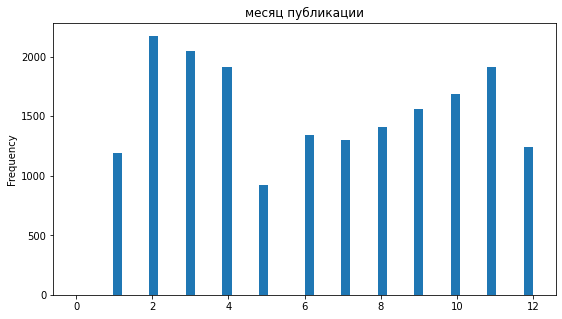

In [54]:
data['month'].plot( kind = 'hist',title = 'месяц публикации', bins = 50 , range = (0,12), figsize = (9,5));

**Вывод:** большинство квартир имеют площадь менее 100 квадратных метров, в датасете есть несколько вариантов больше 200 метров (доходит до 900) - скорее всего это элитная недвижимость в Санкт-Петербурге, средняя площадь квартиры - 60 квадратных метров. Самые распространённые варианты с жилой площадью от 10 до 50 метров. После 80 метров встречаются единичные случаи. по графику видно, что большинство квартир либо 1 комнатные, либо 2 комнатные. Площадь кухни также доказывает, что квартиры, представленные в датасете, небльшие, так как площаь кухни в основном составляет 10 квадратных метров. Большиснтво квартир расположены на 1-4 этажах, а также большое количество расположено на 5 этаже, можно предпопложить, что основную часть выборки составяют квартиры в так называемых "Хрущевках" (это также подтверждается графиком с общим кол-вом этажей в доме, при этом довольно сильно распространены 10-этажки). Высота потолков, в основном составляет 2,5 метра (стандартная высота для российского жилья). Многие продававшиеся квартиры находятся не на первом и не на последнем этаже. Стоимость жилья в основном варьируется на отметке в 5 миллионов рублей. Многие квартиры расположены в пешей достпуности к паркам (450 метров), находятся на расстоянии в 10 километрах от аэропорта (внутри города), а также недалеко от центра (пик в 300 метрах6 а также 500-650 и 750 метров). День недели публикации объявления распереден равномерно с сильным спадом ближе к выходным. Больше всего квартиры размещаются в начале и конце года, со спадом в мае и летних месяцах, также наблюдается спад в январе и декабре.

**Далее** необходимо проанализировать как быстро продавались квартиры

count    15917.000000
mean       111.113087
std         97.775733
min          1.000000
25%         38.000000
50%         77.000000
75%        162.000000
max        399.000000
Name: days_exposition, dtype: float64

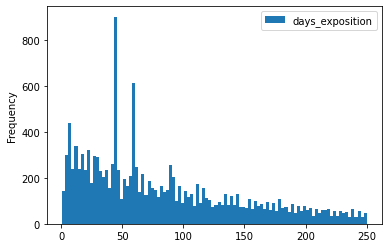

In [55]:

data.plot(y = 'days_exposition', kind = 'hist', bins = 100, range = (1,250))

data[data['days_exposition']!=0]['days_exposition'].describe()


**Вывод:** Медианное время продажи - 95 дней. Среднее время продажи - 181 день.
Есть большое количество жилья, проданного за 50 дней. Также есть большое число квартир, проданных всего за несколько дней после публикации. А также есть варианты, которые продавались несколько десятков месяцев.


### Проанализируем факторы, которые наиболее влияют на общую стоимость объекта

1) Зависимость цены от площади квартиры

0.22792712434492327

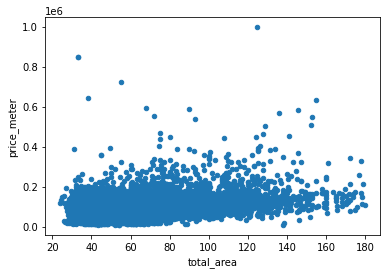

In [56]:
data.plot(x = 'total_area', y = 'price_meter', kind = 'scatter');


data['total_area'].corr(data['price_meter'])



2) Зависимость цены от жилой площади квартиры

0.1340325882928151

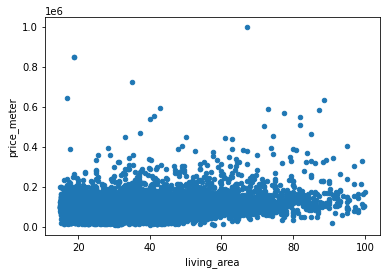

In [57]:
data.plot(x = 'living_area', y = 'price_meter', kind = 'scatter');
data['living_area'].corr(data['price_meter'])

3) Зависимость цены от площади кухни квартиры

0.3310739889061977

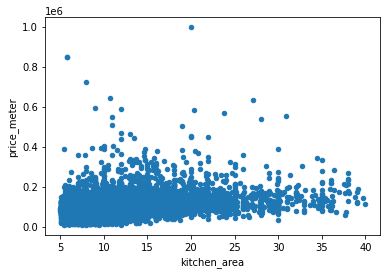

In [58]:
data.plot(x = 'kitchen_area', y = 'price_meter', kind = 'scatter');

data['kitchen_area'].corr(data['price_meter'])

4) Зависимость цены и количества комнат

-0.031922106538337686

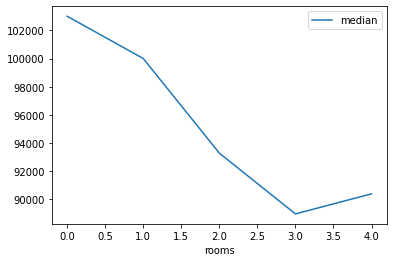

In [59]:
pivot_table_total_area = data.pivot_table(index = 'rooms', values = 'price_meter', aggfunc = ['median'])
pivot_table_total_area.columns = ['median']
pivot_table_total_area.plot(y = 'median')


data['rooms'].corr(data['price_meter'])

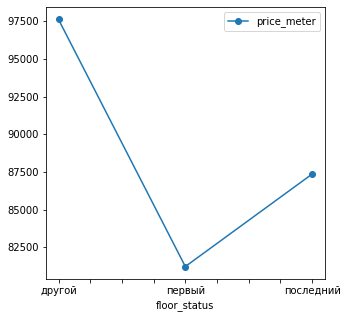

In [60]:
(data.pivot_table(index='floor_status', values='price_meter', aggfunc='median').plot( style='o-', figsize=(5, 5)))
plt.show()


-0.0122529918117748

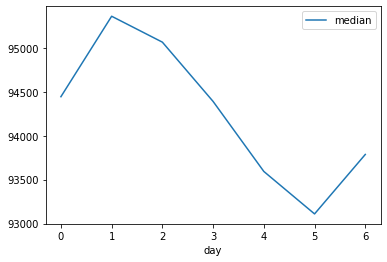

In [61]:
pivot_table_total_area = data.pivot_table(index = 'day', values = 'price_meter', aggfunc = ['median'])
pivot_table_total_area.columns = ['median']
pivot_table_total_area.plot(y = 'median')


data['day'].corr(data['price_meter'])

-0.004286337215142957

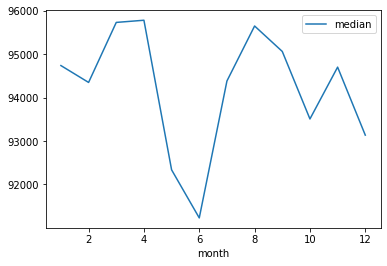

In [62]:
pivot_table_total_area = data.pivot_table(index = 'month', values = 'price_meter', aggfunc = ['median'])
pivot_table_total_area.columns = ['median']
pivot_table_total_area.plot(y = 'median')


data['month'].corr(data['price_meter'])

-0.0434947400124368

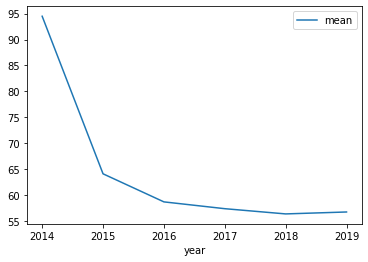

In [63]:
pivot_table_total_area = data.pivot_table(index = 'year', values = 'total_area', aggfunc = ['mean'])
pivot_table_total_area.columns = [ 'mean']
pivot_table_total_area.plot(y = 'mean')


data['year'].corr(data['total_area'])

0.046085367081621385

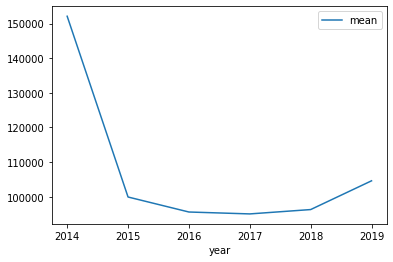

In [64]:
pivot_table_total_area = data.pivot_table(index = 'year', values = 'price_meter', aggfunc = ['mean'])
pivot_table_total_area.columns = ['mean']
pivot_table_total_area.plot(y = 'mean')


data['year'].corr(data['price_meter'])

**Вывод:** Чем больше площадь - тем выше стоимость квартиры (высокая корреляция). Площадь кухни также сильно влияет на цену квартиры, при этом жилая площадь менее сильно влияет на цену квартиры (что интересно). Скорее всего, кухня больше влияет на цену квартиры, так как люди там проводят большинство своего времени. Число комнат влияет на цену (больше комнат - больше цена), однако зависимость ниже, чем у площади. Первый этаж непосредственно влияет на стоимость квартиры - квартиры на 1-м этаже значительно дешевле. Чуть дороже последний этаж. Наибольшая стоимость у квартир, расположенных не на 1-м и не на последнем этаже. Рассмотрим зависимость от дня/недели и года размещения. День недели: дороже всего квартиры, опубликованные во вторник, дешевле всего - в субботу.
Месяц: дороже всего квартиры, продающиеся с апреля, дешевле всего - с мая.
Год: квартиры очень сильно подешевели в 2015-2017 годах, что, вероятно, кризисами в экономике и политике в России после событий 2014 года. В 2018 году цены снова стали повышаться на фоне роста благосостотояния граждан и государственных программах в сфере недвижимости

0.7088806052512869

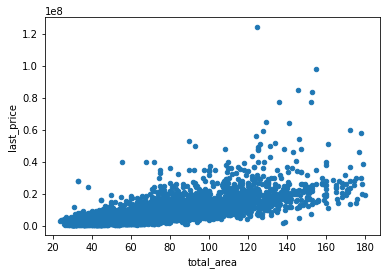

In [65]:
data.plot(x = 'total_area', y = 'last_price', kind = 'scatter');


data['total_area'].corr(data['last_price'])

0.601881325701627

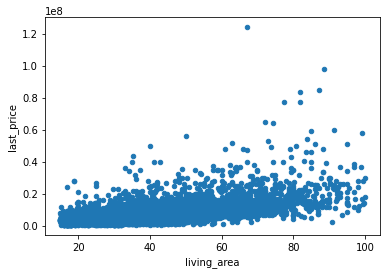

In [66]:
data.plot(x = 'living_area', y = 'last_price', kind = 'scatter');


data['living_area'].corr(data['last_price'])



0.5427215283617142

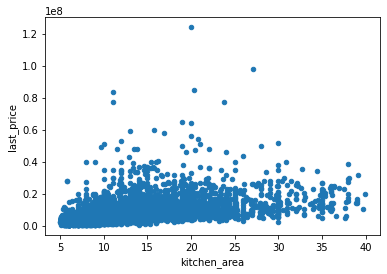

In [67]:
data.plot(x = 'kitchen_area', y = 'last_price', kind = 'scatter');


data['kitchen_area'].corr(data['last_price'])

0.3867673097026851

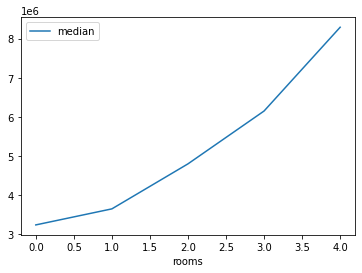

In [68]:
pivot_table_total_area = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['median'])
pivot_table_total_area.columns = ['median']
pivot_table_total_area.plot(y = 'median')


data['rooms'].corr(data['last_price'])

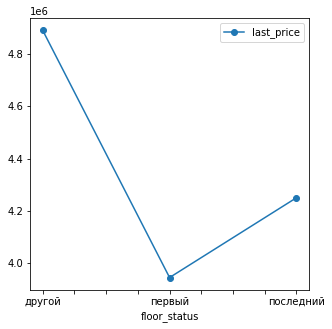

In [69]:
(data.pivot_table(index='floor_status', values='last_price', aggfunc='median').plot( style='o-', figsize=(5, 5)))
plt.show()

-0.011937057681492912

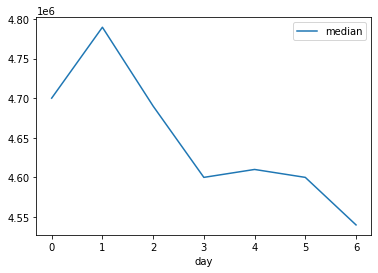

In [70]:
pivot_table_total_area = data.pivot_table(index = 'day', values = 'last_price', aggfunc = ['median'])
pivot_table_total_area.columns = ['median']
pivot_table_total_area.plot(y = 'median')


data['day'].corr(data['last_price'])

0.007338178910859261

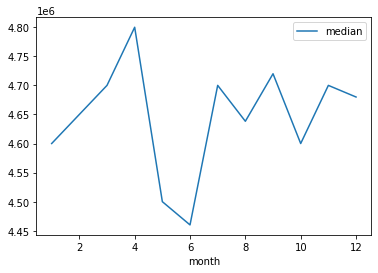

In [71]:
pivot_table_total_area = data.pivot_table(index = 'month', values = 'last_price', aggfunc = ['median'])
pivot_table_total_area.columns = ['median']
pivot_table_total_area.plot(y = 'median')


data['month'].corr(data['last_price'])

-0.007714368375294356

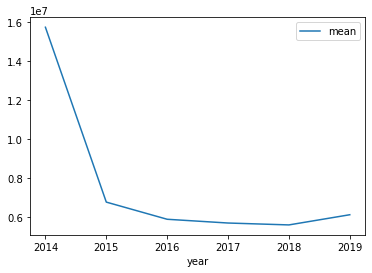

In [72]:
pivot_table_total_area = data.pivot_table(index = 'year', values = 'last_price', aggfunc = ['mean'])
pivot_table_total_area.columns = ['mean']
pivot_table_total_area.plot(y = 'mean')


data['year'].corr(data['last_price'])

Построии графики зависимости общей стоимости квартиры от 8 факторов. Общая площадь играет наиброльшую роль в формировании общей стоимости квартиры, чуть меньше влияют жилая площадь и площадь кухни. Чуть меньше влияет количество комнат (чем их больше - тем общая стоимость выше), а также влияет на общую стоиомость квартиры ее этаж

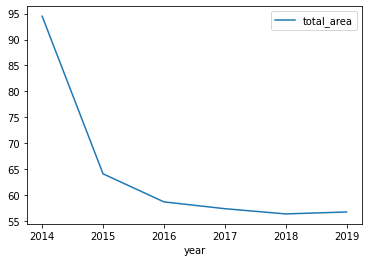

In [87]:
# check
data.pivot_table(index = 'year', values = 'total_area').plot();

### check top-10

**Далее** Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [74]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table

,count,mean
locality_name,,
санкт-петербург,12489,111745.942750
поселок мурино,367,83380.991826
поселок шушары,348,76845.089080
всеволожск,311,69105.102894
колпино,290,75240.958621
пушкин,277,103143.068592
гатчина,246,69662.995935
поселок парголово,236,87072.190678
деревня кудрово,211,91156.355450


In [75]:
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()] #самая высокая стоимость

,count,mean
locality_name,,
санкт-петербург,12489,111745.94275


In [76]:

locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()] #самая низкая стоимость жилья

,count,mean
locality_name,,
выборг,188,58097.180851


**Теперь** выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра.

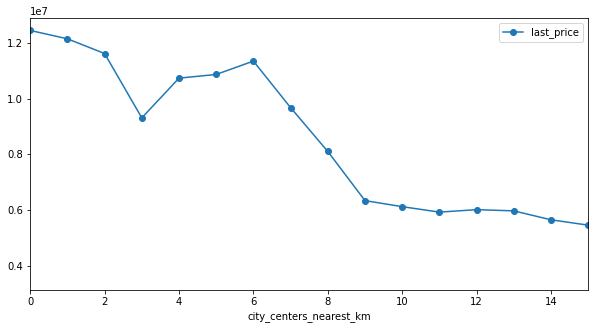

In [77]:
(data.query('locality_name == "санкт-петербург"').pivot_table(index='city_centers_nearest_km', values='last_price').plot(style='o-', xlim=(0,15), figsize=(10, 5)))
plt.show()

**Вывод:** Наибольшее число объявлений приходится на Санкт-Петербург (что довольно логично), средняя цена квадратного метра составляет почти 115 тысяч рублей. На втором месте идет Мурино - этот поселок сейчас густо населен, это настоящий "человейник" - в СМИ его нередко называют "гетто", при этом он является поппулярным среди людей, переезжающих в Петербург, так как расположен рядом с городом и имеет близкое расположение к станции метро "Девяткино" и выход к КАД. Наименьшая цена квадратного метра в Выборге - чуть больше 58 тысяч рублей - город расположен на значительном расстоянии от Санкт-Петербурга, добраться до города можно на "Ласточке" за 2 часа или на автомобиле также примерно за 2 часа. В Санкт-Петербурге условно центром считается расстояние до 7 км - дальше цена резко снижается. В 6 километрах, напрмиер, находится район "Петроградская" и "Приморский", которые обладают высокой стоимостью жилья (прежде всего из-за инфраструктуры и месторасположения)

### Общие выводы по проекту

На первом этапе полученный датасет был обработан от ошибок (пропущенные значения, неверные имена столбцов, неверный формат данных, аномальные значения). 
Далее добавили новые столбцы с ценой квадратного метра, со временем публикации объявлений, с типом этажа, расстоянием до центра города в километрах.

После этого изучили следующие параметры: - площадь (общая, жилая, кухни), цена, число комнат, высота потолков, расстояние до аэропорта, центра, парков.  
Нами было выявилено, что на стоимость квадратного метра квартиры больше всего влияют общая площадь и площадь кухни, количество комнат (в меньшей степени), этаж квартиры (первый этаж наиболее дешевый - дороже всего квартиры не на первом и не на последнем этаже), близость к центру.
Незначительно на стоимость квадратного метра влияют время размещения объявления и площадь комнаты. 
Было выявлено, что на рынке недвижимости произошел спад средней площади квартир, при этом выросла их стоимость, что говорит о росте средней стоимости квадратного метра. 
Было выявлено, что многие квартиры расположены на 1-4 этаже, а также много квартир на 5 (скорее всего, большинство квартир - "Хрущевки")
Наибольшая стоимость квартратного метра - в Санкт-Петербурге, наименьшая - в Выборге.
Чаще всего квартиру продают за 95 дней. Есть большое число квартир, проданных всего за несколько дней после публикации, а также те квартиры, которые продавались несколько месяцев.

Центр Петербурга можно охарактеризовать как 7км расастояние от условного центра города. 
